In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Data Loading

In [62]:
PATH = "/Users/mikolajstarczewski/Desktop/Magisterka/NN_with_py/nn_with_py/data_files/"

# Load data
X_train = np.load(PATH + "X_train.npy")
X_test = np.load(PATH + "X_test.npy")
Y_train = np.load(PATH + "Y_train_ohe.npy")
Y_test = np.load(PATH + "Y_test_ohe.npy")

# Flattening Data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Define the neural network architecture

In [63]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(128, 89)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout2(x)
        x = self.fc5(x)
        return self.softmax(x)


In [64]:
model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)


# Training loop

In [65]:
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    _, labels = torch.max(targets, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / targets.size(0)
    return accuracy

In [66]:
def train_model(model, X_train, Y_train, X_test, Y_test, epochs=3, batch_size=128):
    train_size = X_train.shape[0]
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_corrects = 0
        
        # Shuffle the data for each epoch
        permutation = torch.randperm(train_size)
        
        for i in range(0, train_size, batch_size):
            optimizer.zero_grad()

            # Get batch data
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], Y_train[indices]

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Calculate accuracy for training
            acc = calculate_accuracy(outputs, batch_y)
            running_loss += loss.item() * batch_x.size(0)
            running_corrects += acc * batch_x.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        # Calculate average training loss and accuracy
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, Y_test).item()
            val_acc = calculate_accuracy(val_outputs, Y_test)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    return history

In [67]:
history = train_model(model, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, epochs=5, batch_size=128)

Epoch 1/5 | Train Loss: 4.3994 | Train Acc: 0.1069 | Val Loss: 4.3743 | Val Acc: 0.1331
Epoch 2/5 | Train Loss: 4.3176 | Train Acc: 0.1901 | Val Loss: 4.2979 | Val Acc: 0.2099
Epoch 3/5 | Train Loss: 4.2743 | Train Acc: 0.2334 | Val Loss: 4.2638 | Val Acc: 0.2440
Epoch 4/5 | Train Loss: 4.2503 | Train Acc: 0.2573 | Val Loss: 4.2448 | Val Acc: 0.2630
Epoch 5/5 | Train Loss: 4.2342 | Train Acc: 0.2734 | Val Loss: 4.2209 | Val Acc: 0.2868


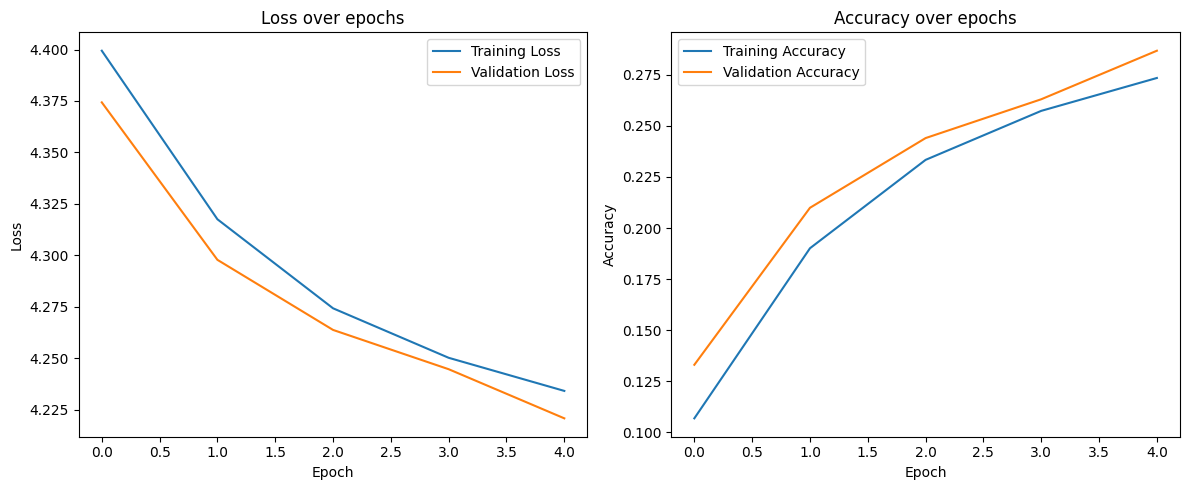

In [68]:
# Plotting training loss, training accuracy, validation loss, and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save load Model

In [ ]:
def save_model(model, file_path="model.pth"):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

def load_model(file_path="model.pth"):
    model = NeuralNetwork()
    model.load_state_dict(torch.load(file_path))
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {file_path}")
    return model

    